In [1]:
from Bio import SeqIO, SeqUtils, Seq
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import random; random.seed("02091994")
import copy

In [2]:
def autocorr_dinuc_groups(sequence,
                          autocorr_range = 150,
                          dinuc_group=['AT', 'GC'],
                          smoothing=True,
                          smoothing_range=3,
                          subtract_bg=True,
                          bg_range=11):
    """
    Calculcates autocorrelations in groups of dinucleotides.
    E.g. dinuc_group AT is interpreted as A/T which is AA, TT, AT, TA.
    """
    
    if subtract_bg:
        if not smoothing:
            return(print("Smooth needs to be true if bgsub is true"))
    
    
    autocorrelation = {}
    autocorrelation_smooth = {}
    autocorrelation_bgsub = {}
    for dg in dinuc_group:
    
        dinucs = []
        combinations = itertools.product(dg, repeat=2)
        for i in combinations:
            dinucs.append(i[0]+i[1])
    
        autocorrelation[dg] = [0]*autocorr_range
        for pos in range(len(sequence)-autocorr_range):
            if sequence[pos:pos+2] in dinucs:
                for count in range(0, autocorr_range):
                    new_pos = pos + count
                    if sequence[new_pos:new_pos+2] in dinucs:
                        autocorrelation[dg][count] += 1


        if smoothing:

            # smooth the autocorrelation by a 3bp window
            for dinuc in autocorrelation:
                new_list = [0] * len(autocorrelation[dg])
                for i, entry in enumerate(autocorrelation[dg]):
                    if (i+smoothing_range) <= len(autocorrelation[dg]):
                        middle_of_window = i + (smoothing_range//2)
                        new_list[middle_of_window] = np.mean(autocorrelation[dg][i:i+smoothing_range]) 
                autocorrelation_smooth[dg] = new_list


        if subtract_bg:

            # calculate the bg of 11bp and subtract it from the autocorrelation
            for dinuc in autocorrelation_smooth:
                bg = [0] * len(autocorrelation_smooth[dg])
                for i, entry in enumerate(autocorrelation_smooth[dg]):
                    if (i+bg_range) <= len(autocorrelation_smooth[dg]):
                        middle_of_window = i + (bg_range//2)
                        bg[middle_of_window] = np.mean(autocorrelation_smooth[dg][i:i+bg_range]) 
                autocorrelation_bgsub[dg] = [a_i - b_i for a_i, b_i in zip(autocorrelation_smooth[dg], bg)]
                
    if subtract_bg:
        return(autocorrelation, autocorrelation_smooth, autocorrelation_bgsub)
    elif smoothing:
        return(autocorrelation, autocorrelation_smooth)
    else:
        return(autocorrelation)

In [3]:
def is_dinuc_YY(dinuc):
    YY = ["C", "T"]
    if dinuc[0] in YY and dinuc[1] in YY:
        return True
    else: return False

In [4]:
def is_dinuc_RR(dinuc):
    RR = ["A", "G"]
    if dinuc[0] in RR and dinuc[1] in RR:
        return True
    else: return False

In [5]:
def mod_sequence_YY(in_seq, period, skip_chance = 0.5, overwrite=False):
    
    if overwrite:
        mod_Kana = in_seq
    else:
        mod_Kana = copy.copy(in_seq)


    for i, nuc in enumerate(in_seq):

        i_dinuc = in_seq[i:i+2]

        #failsave
        if len(i_dinuc) != 2 or i >= (len(in_seq) - (4*period)):
            continue

        if is_dinuc_YY(i_dinuc):

            j = i + period
            
            
            # define the following 3 dinucleotides in the periodic distance together with coordinates
            j_dinuc = [ in_seq[j:j+2], (j, j+2) ]

            j2_dinuc = [ in_seq[ (j+period) : (j+period) + 2], (j+period, j+period+2) ]

            j3_dinuc = [ in_seq[ (j+2*period) : (j+2*period) + 2], (j+(2*period), j+(2*period)+2) ]


            for period_dinuc, coord in [j_dinuc, j2_dinuc, j3_dinuc]: 
                # only do it for some of the following dinucs, defined by chance
                if np.random.choice(np.array([True, False]), 1, p = [skip_chance, 1-skip_chance]):
                    continue
                    
                    
                elif not is_dinuc_YY(period_dinuc):

                    # replace every Purine in the dinucleotide by a random Pyrimidine
                    
                    if period_dinuc[0] not in ["C", "T"]:
                        mod_Kana[coord[0]] = random.choice(["T", "C"])
                        #in_seq[j] = random.choice(["T", "C"])
                    if period_dinuc[1] not in ["C", "T"]:
                        mod_Kana[coord[1]] = random.choice(["T", "C"])
                        #in_seq[j + 1] = random.choice(["T", "C"])


                # will this change the GC too much?
                # is the frequency of pyrimidine nucleotides too different?

    mod_Kana = "".join(mod_Kana)
    
    return(mod_Kana)

In [6]:
def mod_sequence_RR(in_seq, period, skip_chance = 0.5, overwrite=False):
    
    if overwrite:
        mod_Kana = in_seq
    else:
        mod_Kana = copy.copy(in_seq)


    for i, nuc in enumerate(in_seq):

        i_dinuc = in_seq[i:i+2]

        #failsave
        if len(i_dinuc) != 2 or i >= (len(in_seq) - (4*period)):
            continue

        if is_dinuc_RR(i_dinuc):

            j = i + period
            
            
            # define the following 3 dinucleotides in the periodic distance together with coordinates
            j_dinuc = [ in_seq[j:j+2], (j, j+2) ]

            j2_dinuc = [ in_seq[ (j+period) : (j+period) + 2], (j+period, j+period+2) ]

            j3_dinuc = [ in_seq[ (j+2*period) : (j+2*period) + 2], (j+(2*period), j+(2*period)+2) ]


            for period_dinuc, coord in [j_dinuc, j2_dinuc, j3_dinuc]: 
                
                # only do it for some of the following dinucs, defined by chance
                if np.random.choice(np.array([True, False]), 1, p = [skip_chance, 1-skip_chance]):
                    continue
                    
                    
                elif not is_dinuc_RR(period_dinuc):

                    # replace every Pyrimidine in the dinucleotide by a random purine
                    
                    if period_dinuc[0] not in ["A", "G"]:
                        mod_Kana[coord[0]] = random.choice(["A", "G"])
                    
                    if period_dinuc[1] not in ["A", "G"]:
                        mod_Kana[coord[1]] = random.choice(["A", "G"])
                        

                # will this change the GC too much?
                # is the frequency of pyrimidine nucleotides too different?

    mod_Kana = "".join(mod_Kana)
    
    return(mod_Kana)

In [8]:
seq_dic = {}
for entry in SeqIO.parse("sequences/sequences.fa", "fasta"):
    seq_dic[entry.description] = entry.seq.upper()

In [9]:
mod_Kana = mod_sequence_YY(list(seq_dic["KanaStuffer"]), period = 15, skip_chance = 0.8, overwrite = True)

In [10]:
mod_Kana

'CATGCTGGGGAGAACGCCGTCCTCCCTCACCGCTGACGTGCTCCCTGCGGGCACCGAGGCTGGAGTCGGCCCCGGCGAGGAGTTTCTCCAAACGTTGGTACCCGGAGTATCTTCCACCCGCAAGTTTCTCGCCGCCTCCGGGGCATGTCTTTCCCCCACCCCTTTCCCTTATTCATTCGTTTTCAGTTCACGTTCGTTCGCGGTACCTCACGTATGCCATATCGTCTCTAGCTCCTAAGTCCCTTTCCTGTAGTGCAAACCCAACGCGTCTCTCCTTCCGCGACTCTCTGTCCGCGGAATCGCCGCTGAGGAGTTTGTGCTACTATTTTTTTGCAAGGTAGGAAGCCAAGTACCTTCCCGTGCTCGTCCCAGCTTTCTTGTACACAGTTGGCATTATTATTATGCTTTTCTTATCAATTTTTTGTATCGAACAGGTCACTATCAGTCATACTTATCTCATTATTTGCCATCCACCTGCAGCTCTCTTCCTTGTCTCTACATCTCTGATCCTATATTGCTCACCTCCATAATATTTCCTCTTGAACACTAATATTCTCTGCTTACATAACCATTATTACATTGCGCGCTATGAGCCATATTCCACTGCAAACGTCTATGCCGCGATTAAATTCCCACATGGATTCTCACTTATATGGGTACAAATGGGCTCGCGTTATTGTCGTGTAATCAGGTGCGTCAATCTATCGCTTGTATGGGACTCCCGATGCGCCATATTTCTTTCTGCTTTATGTCAAAGGTCGCGTTGCCTACCATGTTACATTCGCCTTGGTCAGACTAAACTGGCTGACGTATTTTATGCCTCTTCCTTTCCTCCACCATTTTATCCTTTCTCCTTATTCTGCCTTGTTTCTCACCTCTGCGATCCCCTGTATCATAGCTCTCCAGGTATTAGCACATTCTCCTGATTCTGCTGCAAATATTGTTGCTGCGCTGGCAGTGTTCCTCCGCCCGCTGCATTCCACTCCTGTTTGTAATTGT

(-35.0, 35.0)

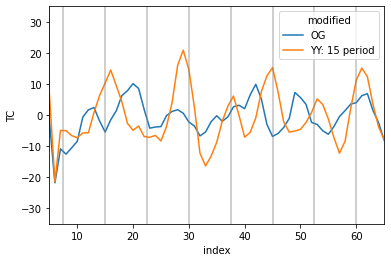

In [19]:
spacing = 7.5

fig, ax = plt.subplots(figsize = (6, 4))

df = pd.DataFrame(autocorr_dinuc_groups(seq_dic["KanaStuffer"],
                          autocorr_range = 75,
                          dinuc_group=["TC"],
                          smoothing=True,
                          smoothing_range=3,
                          subtract_bg=True,
                          bg_range=11)[2])
df["modified"] = "OG"
df["index"] = df.index


df_temp = pd.DataFrame(autocorr_dinuc_groups(mod_Kana,
                          autocorr_range = 75,
                          dinuc_group=["TC"],
                          smoothing=True,
                          smoothing_range=3,
                          subtract_bg=True,
                          bg_range=11)[2])
df_temp["modified"] = "YY: 15 period"
df_temp["index"] = df_temp.index

df = df.append(df_temp).reset_index(drop = True)

sns.lineplot(y = "TC", x = "index", data = df, hue="modified")

for x in np.linspace(0, 10*spacing, 11):
    plt.axvline(x, color="grey", alpha=0.5)

plt.xlim(5,65)
plt.ylim(-35,35)

In [385]:
SeqUtils.GC(mod_Kana)

48.22616407982262

In [386]:
SeqUtils.GC(list(seq_dic["KanaStuffer"]))

47.006651884700666

In [387]:
with open("mod_KanaStuffer_YY7.fasta", "w") as out:
    out.write(">mod_KanaStuffer_YY7\n")
    out.write(mod_Kana)
    out.write("\n")

In [388]:
seq_dic["KanaStuffer"]

Seq('CATGCTGGGGAGAACGCCGTCCTCCCTCACCGCTGAAGTGCTCCCTGCGGGCAC...AGT')

CATGCTGGGGAGAACGCCGTCCTCCCTAACCCCGGAACTGTTCCCTCCGGGCAAATGGCCTCGTTTCGTTATACGTACCCAGCTACTCCTAACGTTGTGGTCCGAATTATAAACCATACACAAGTACCCCGCCGCCCCGTGCGGACTGCTTTAGACCCGTTGTTTCCGATCTCCAGTCCCCTACGGTTCACCTTGGCTCGCCCTACCTCACGCACCGCGCCTCCTCTCTCATCCGTCATGCCCTTTCTTACACTTATGACCCTACGCCACTCTCTCTCCAGTATTCTCTCTTTCCGCATTCATTCTTGAGGAGTACCTTCTATTATGATACTACGTGGGAGGGATACGCGGATCTGCGCAGGGTAGACCACATGGTGAGGGACGGCGTAAGCACTATTAAGGAGCATCCATGATAAATGTGGTCCGCGGCGCAGGTAATACTAAGTCAAAATACCAAATTCACTGGCTTTACACCTGCAGCTCTGTCCCTTGCGTCGACATGTCTGGTACGTTATTGGCATAGATCTCGTTCTTTCATCCGCACGATATTATCTGTCTGCATCGTGGTATTTTATTACTTGCCGTTGAATAATCGATTTTCTAAAGCATACGGCCATGCCGCTACTAAAATGATATATGCATGCTACAAAATAAGGGGTATCATGGGAAGACAGGCGTGTCGGGCAATGCGGTAGGAAAATCAATGGCGTGGGTAGGAACGCCGATACGCAAGTGTTGACGCTGTTTCATGCAAAAGGAAGGGTTGCGTATGAAGCATTATATGCGATAGTAAGAGTGCAATGGCTGACGTATTTTAGGCAACGGGCCATCATAAAGCGTGACATGCGTACGCAGGTTTCAGGACGTATACTCACCAGTGCGATCCCGGCACAAACTGTACTGCCGCTAACACCCTTCTATCCGGATACACCTGAGTATATTGTGGTTGCGTTGGCGTGCTTCCTGAGCCGGTCGTATACGATTCCAGTATGTCACGTGC

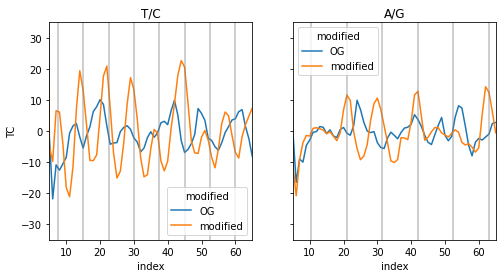

In [21]:
seq_dic = {}
for entry in SeqIO.parse("sequences.fa", "fasta"):
    seq_dic[entry.description] = entry.seq.upper()

# iterate a number of times over both Pyrimidne and purine seqeunce alteration functions to get a an overall predisposition towards the wanted periodicities
for i in range(64):
    if i == 0:
        mod_Kana_YY = mod_sequence_YY(list(seq_dic["KanaStuffer"]), period = 15, skip_chance = 0.99)
        mod_Kana_RR = mod_sequence_RR(list(mod_Kana_YY), period = 21, skip_chance = 0.99)
    else:
        mod_Kana_YY = mod_sequence_YY(list(mod_Kana_RR), period = 15, skip_chance = 0.99)
        mod_Kana_RR = mod_sequence_RR(list(mod_Kana_YY), period = 21, skip_chance = 0.99)

# check the sequence for apparant homopolymer stretches
print(mod_Kana_RR)



fig, ax = plt.subplots(1, 2, figsize = (8, 4), sharex = True, sharey=True)
plt.xlim(5,65)
plt.ylim(-35,35)


# calculate the autocorrelation for dinucleotides for the unmodified and modified sequence
df = pd.DataFrame(autocorr_dinuc_groups(seq_dic["KanaStuffer"],
                          autocorr_range = 75,
                          dinuc_group=["AG", "TC"],
                          smoothing=True,
                          smoothing_range=3,
                          subtract_bg=True,
                          bg_range=11)[2])
df["modified"] = "OG"
df["index"] = df.index

df_temp = pd.DataFrame(autocorr_dinuc_groups(mod_Kana_RR,
                          autocorr_range = 75,
                          dinuc_group=["AG", "TC"],
                          smoothing=True,
                          smoothing_range=3,
                          subtract_bg=True,
                          bg_range=11)[2])
df_temp["modified"] = "modified"
df_temp["index"] = df_temp.index

# combine into same dataframe
df = df.append(df_temp).reset_index(drop = True)

# plot line plots
sns.lineplot(y = "TC", x = "index", data = df, hue="modified", ax = ax[0])
ax[0].set_title("T/C")

sns.lineplot(y = "AG", x = "index", data = df, hue="modified", ax = ax[1])
ax[1].set_title("A/G")

# define spacing for the grey lines
spacing_TC = 7.5    
spacing_AG = 10.5
# plot lines to indicate periods
for x in np.linspace(0, 10*spacing_TC, 11):
    ax[0].axvline(x, color="grey", alpha=0.5)
for x in np.linspace(0, 10*spacing_AG, 11):
    ax[1].axvline(x, color="grey", alpha=0.5)



In [438]:
with open("mod_KanaStuffer_YY7.5_RR10.5.fasta", "w") as out:
    out.write(">mod_KanaStuffer_YY7.5_RR10.5\n")
    out.write(mod_Kana_RR)
    out.write("\n")

# Plot the modified sequence together with the other ones
Replaced the old stuffer with the modified stuffer in the original sequences file

In [439]:
aav_seq = {}
for entry in SeqIO.parse("../get_sequences/sequences.fa", "fasta"):
    aav_seq[entry.description] = entry.seq.upper()

In [440]:
autocorr_aav = {}
for serotype in aav_seq:
    autocorr_aav[serotype] = autocorr_dinuc_groups(
        aav_seq[serotype],
        dinuc_group = ["GC", "AT", "AG", "TC"],
        subtract_bg = True
    )[2]
    
    
serotype_autocorrelation = pd.DataFrame()
for serotype in autocorr_aav:
    temp_df = pd.DataFrame(autocorr_aav[serotype]).reset_index().melt(id_vars = "index", var_name="dinucleotide", value_name="autocorr")
    temp_df = temp_df.rename(columns={"index":"distance"})
    temp_df["serotype"] = serotype
    serotype_autocorrelation = serotype_autocorrelation.append(temp_df)

# reset the index
serotype_autocorrelation = serotype_autocorrelation.reset_index(drop=True)


hue = []
for lbl in list(serotype_autocorrelation["serotype"]):
    if "serotype" in lbl:
        hue.append("WT")
    elif lbl == "GFPKana":
        hue.append("GFPKana")
    else:
        hue.append("rnd_seq")
        
serotype_autocorrelation["hue"] = hue

GFPkana_autocorrelation = serotype_autocorrelation.loc[serotype_autocorrelation["hue"] != "WT"]
serotype_autocorrelation = serotype_autocorrelation.loc[serotype_autocorrelation["hue"] != "GFPKana"]

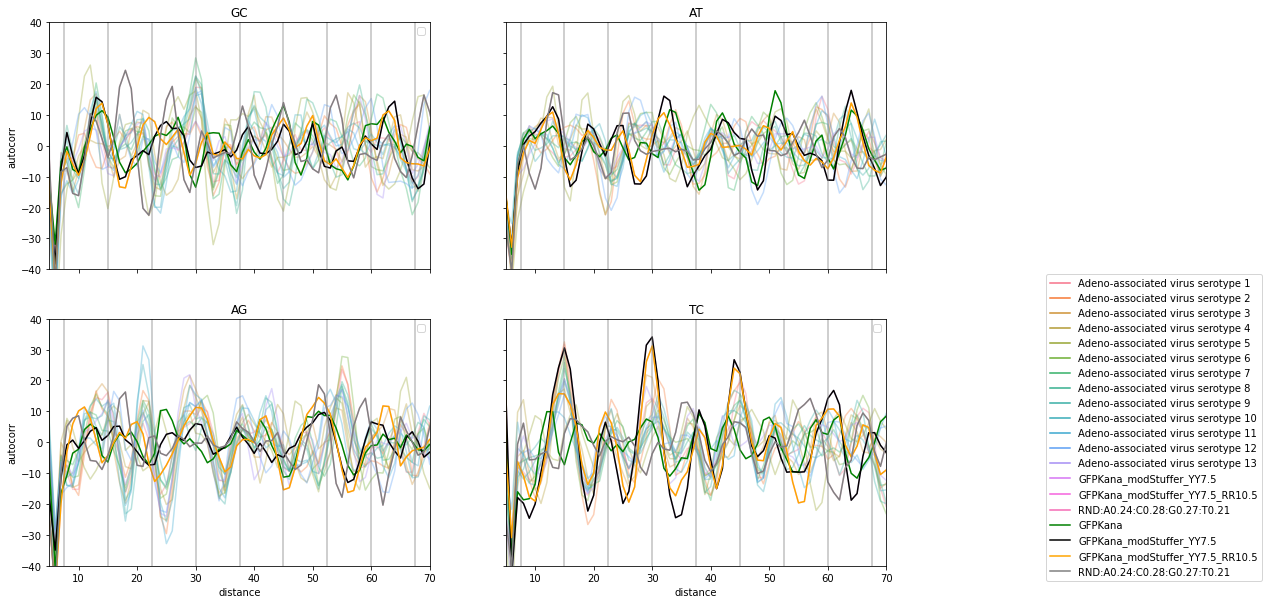

In [442]:
fig, ax = plt.subplots(2,2, figsize=(15,10), sharex=True, sharey=True)


plt.xlim(5, 70)
plt.ylim(-40, 40)

row = 0
col = 0

for i, dinuc in enumerate(["GC", "AT", "AG", "TC"]):
    ax[row, col].set_title(dinuc)
    sns.lineplot(
        x="distance",
        y="autocorr",
        hue="serotype",
        ax=ax[row,col],
        data= serotype_autocorrelation.loc[serotype_autocorrelation["dinucleotide"] == dinuc],
        estimator = None,
        alpha = 0.35
    )
    
    sns.lineplot(
        x="distance",
        y="autocorr",
        hue="serotype",
        ax=ax[row,col],
        data= GFPkana_autocorrelation.loc[GFPkana_autocorrelation["dinucleotide"] == dinuc],
        palette = {
            "GFPKana": "green",
            "GFPKana_modStuffer_YY7.5": "black",
            "GFPKana_modStuffer_YY7.5_RR10.5": "orange",
            "RND:A0.24:C0.28:G0.27:T0.21": "grey"
                  }
    )
      
    
    if i == 1:
        ax[row,col].legend(bbox_to_anchor=(2, 0))
    else:
        ax[row,col].legend([])

    for x in np.linspace(0, 10*spacing, 11):
        ax[row, col].axvline(x, color="grey", alpha=0.5)
    
    col += 1
    if col == 2:
        row+=1
        col=0

The modified GFPKana sequence shows the same T/C nucleotide repeat while not showing the A/G one. Good.

To do:

* create one sequence that has the A/G repeat
* create one that has both
* add a section of inert cap gene as a stuffer

It is easy to manipulate the frequency when you have complete freedom of sequence. It will be more challenging in the protein coding regions

# What about the GC and base frequencies in the new sequences?

In [24]:
seq_dic

{'GFPKana': Seq('TGTAGTTAATGATTAACCCGCCATGCTACTTATCTACGTAGCCATGCTCTAGAG...ACA'),
 'KanaStuffer': Seq('CATGCTGGGGAGAACGCCGTCCTCCCTCACCGCTGAAGTGCTCCCTGCGGGCAC...AGT'),
 'RND:A0.24:C0.28:G0.27:T0.21': Seq('TTCTCCTCGCGCTCGCATCCGGGCCGATCATGGACTCTAAATTTGAAAACAATT...CAC')}

In [31]:
seq_dic_mod = {}
for entry in SeqIO.parse("sequences_final.fa", "fasta"):
    seq_dic_mod[entry.description] = entry.seq.upper()
    
aav_seq = {}
for entry in SeqIO.parse("../get_sequences/sequences.fa", "fasta"):
    aav_seq[entry.description] = entry.seq.upper()
    
aav_seq.pop('GFPKana_modStuffer_YY7.5', None)
aav_seq.pop('GFPKana_modStuffer_YY7.5_RR10.5', None)

Seq('TGTAGTTAATGATTAACCCGCCATGCTACTTATCTACGTAGCCATGCTCTAGAG...ACA')

In [32]:
seq_dic_all = {**seq_dic, **seq_dic_mod, **aav_seq}
seq_dic_all

{'GFPKana': Seq('TGTAGTTAATGATTAACCCGCCATGCTACTTATCTACGTAGCCATGCTCTAGAG...ACA'),
 'KanaStuffer': Seq('CATGCTGGGGAGAACGCCGTCCTCCCTCACCGCTGAAGTGCTCCCTGCGGGCAC...AGT'),
 'RND:A0.24:C0.28:G0.27:T0.21': Seq('TTCTCCTCGCGCTCGCATCCGGGCCGATCATGGACTCTAAATTTGAAAACAATT...CAC'),
 'modStuffer_YY7.5': Seq('GCATGCTGGGGAGAACGCCGTCCTCCCTCACCGCTGAATTGCTCCCTGCGTCTA...AGT'),
 'modStuffer_YY7.5_RR10.5': Seq('GCATGCTGGGGAGAACGCCGTCCTCCCTCAGCGCATTACTGCTCCCTGCGAGTA...AGT'),
 'Adeno-associated virus serotype 1': Seq('TTGCCCACTCCCTCTCTGCGCGCTCGCTCGCTCGGTGGGGCCTGCGGACCAAAG...CAA'),
 'Adeno-associated virus serotype 2': Seq('TTGGCCACTCCCTCTCTGCGCGCTCGCTCGCTCACTGAGGCCGGGCGACCAAAG...CAA'),
 'Adeno-associated virus serotype 3': Seq('TTGGCCACTCCCTCTATGCGCACTCGCTCGCTCGGTGGGGCCTGGCGACCAAAG...CAA'),
 'Adeno-associated virus serotype 4': Seq('TTGGCCACTCCCTCTATGCGCGCTCGCTCACTCACTCGGCCCTGGAGACCAAAG...CAA'),
 'Adeno-associated virus serotype 5': Seq('CTCTCCCCCCTGTCGCGTTCGCTCGCTCGCTGGCTCGTTTGGGGGGGTGGCAGC...GAG'),
 'Adeno-ass

In [55]:
props = {
    "name": [],
    "GC":[],
    "T":[],
    "G":[],
    "C":[],
    "A":[],
    "YY":[],
    "RR":[]
}

for name in seq_dic_all:
    
    props["name"].append(name)
    props["GC"].append(SeqUtils.GC(seq_dic_all[name]))
    for nuc in ["A", "T", "C", "G"]:
        props[nuc].append( seq_dic_all[name].count(nuc) / len(seq_dic_all[name]))
    for dinuc in ["YY", "RR"]:
        props[dinuc].append( ( len(SeqUtils.nt_search(str(seq_dic_all[name]), "YY")) -1 ) / len(seq_dic_all[name]) )
        
props = pd.DataFrame(props)

In [56]:
props

,name,GC,T,G,C,A,YY,RR
0,GFPKana,50.958379,0.244797,0.251369,0.258215,0.245619,0.259036,0.259036
1,KanaStuffer,47.006652,0.275499,0.238359,0.231707,0.254435,0.268293,0.268293
2,RND:A0.24:C0.28:G0.27:T0.21,55.000000,0.210000,0.270000,0.280000,0.240000,0.240625,0.240625
3,modStuffer_YY7.5,47.534626,0.361773,0.144598,0.330748,0.162881,0.471468,0.471468
4,modStuffer_YY7.5_RR10.5,50.415512,0.279778,0.221053,0.283102,0.216066,0.292521,0.292521
5,Adeno-associated virus serotype 1,56.506994,0.197329,0.269818,0.295252,0.237601,0.258372,0.258372
6,Adeno-associated virus serotype 2,53.793546,0.206027,0.268220,0.269716,0.256038,0.248344,0.248344
7,Adeno-associated virus serotype 3,53.872196,0.207364,0.264706,0.274016,0.253915,0.248625,0.248625
8,Adeno-associated virus serotype 4,57.436543,0.187120,0.279631,0.294735,0.238515,0.245018,0.245018
9,Adeno-associated virus serotype 5,55.148643,0.197113,0.266695,0.284791,0.251400,0.255924,0.255924


In [52]:
len(SeqUtils.nt_search(str(seq_dic_all[name]), "YY")) -1

1034